# Getting Started with cuML's accelerator mode (cuml.accel)


cuML is a Python GPU library for accelerating machine learning models using a scikit-learn-like API.

cuML now has an accelerator mode (cuml.accel) which allows you to bring accelerated computing to existing workflows with zero code changes required. In addition to scikit-learn, cuml.accel also provides acceleration to algorithms found in umap-learn (UMAP) and hdbscan (HDBSCAN).

This notebook is a brief introduction to cuml.accel.

# ⚠️ Verify your setup

First, we'll verfiy that we are running on an NVIDIA GPU:

In [1]:
!nvidia-smi  # this should display information about available GPUs

Mon Mar 10 20:48:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

With classical machine learning, there is a wide range of interesting problems we can explore. In this tutorial we'll examine 3 of the more popular use cases: classification, clustering, and dimensionality reduction.

# Classification

Let's load a dataset and see how we can use scikit-learn to classify that data.  For this example we'll use the Coverage Type dataset, which contains a number of features that can be used to predict forest cover type, such as elevation, aspect, slope, and soil-type.

More information on this dataset can be found at https://archive.ics.uci.edu/dataset/31/covertype.

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"

# Column names for the dataset (from UCI Covertype description)
columns = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
           'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
           'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
           'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6',
           'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13',
           'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
           'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27',
           'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
           'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'Cover_Type']

data = pd.read_csv(url, header=None)
data.columns=columns

In [4]:
data.shape

(581012, 55)

Next, we'll separate out the classification variable (Cover_Type) from the rest of the data. This is what we will aim to predict with our classification model. We can also split our dataset into training and test data using the scikit-learn train_test_split function.

In [5]:
X, y = data.drop('Cover_Type', axis=1), data['Cover_Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Now that we have our dataset split, we're ready to run a model. To start, we will just run the model using the sklearn library with a starting max depth of 5 and all of the features. Note that we can set n_jobs=-1 to utilize all available CPU cores for fitting the trees -- this will ensure we get the best performance possible on our system's CPU.  

In [6]:
%%time

clf = RandomForestClassifier(n_estimators=100, max_depth=5, max_features=1.0, n_jobs=-1)
clf.fit(X_train, y_train)

CPU times: user 3min 57s, sys: 1.29 s, total: 3min 58s
Wall time: 2min 29s


RandomForestClassifier(max_depth=5, max_features=1.0, n_jobs=-1)

In about 2 minutes, we were able to fit our tree model using scikit-learn. This is not bad! Let's use the model we just trained to predict coverage types in our test dataset and take a look at the accuracy of our model.

In [7]:
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.7043707993769524

We can also print out a full classification report to better understand how we predicted different Coverage_Type categories.

In [8]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.68      0.68      0.68     42446
           2       0.73      0.78      0.76     56686
           3       0.63      0.86      0.73      7172
           4       0.58      0.39      0.47       541
           5       0.94      0.01      0.02      1897
           6       0.72      0.03      0.06      3423
           7       0.72      0.48      0.58      4038

    accuracy                           0.70    116203
   macro avg       0.72      0.46      0.47    116203
weighted avg       0.71      0.70      0.69    116203



With scikit-learn, we built a model that was able to be trained in just a couple minutes. From the accuracy report, we can see that we predicted the correct class around 70% of the time, which is not bad but could certainly be improved.

Often we want to run several different random forest models in order to optimize our hyperparameters. For example, we may want to increase the number of estimators, or modify the maximum depth of our tree. When running dozens or hundreds of different hyperparameter combinations, things start to become quite slow and iteration takes a lot longer.

We provide some sample code utilizing GridSearchCV below to show what this process might look like. All of these combinations would take a LONG time to run if we spend 2 minutes fitting each model.

In [ ]:
"""
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
"""

Now let's load cuml.accel and try running the same code again to see what kind of acceleration we can get.

In [10]:
%load_ext cuml.accel

[2025-03-10 20:51:44.205] [CUML] [info] cuML: Installed accelerator for sklearn.
[2025-03-10 20:51:55.508] [CUML] [info] cuML: Installed accelerator for umap.
[2025-03-10 20:51:55.521] [CUML] [info] cuML: Installed accelerator for hdbscan.
[2025-03-10 20:51:55.521] [CUML] [info] cuML: Successfully initialized accelerator.


After loading the IPython magic, we need to import the sklearn estimators we wish to use again.

In [11]:
from sklearn.ensemble import RandomForestClassifier

In [12]:
%%time

clf = RandomForestClassifier(n_estimators=100, max_depth=5, max_features=1.0, n_jobs=-1)
clf.fit(X_train, y_train)

CPU times: user 3.48 s, sys: 2.3 s, total: 5.78 s
Wall time: 3.17 s


RandomForestClassifier(max_depth=5, max_features=1.0, n_jobs=-1)

That was much faster! Using cuML we're able to train this random forest model in just seconds instead of minutes. One thing to note is that cuML's implementation of RandomForestClassifier doesn't utilize the `n_jobs` parameter like scikit-learn, but we still accept it which makes it easier to use this accelerator with zero code changes.

Let's take a look at the same accuracy score and classification report to compare the model's performance.

In [13]:
y_pred = clf.predict(X_test)
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           1       0.68      0.69      0.68     42446
           2       0.73      0.78      0.75     56686
           3       0.64      0.86      0.73      7172
           4       0.66      0.44      0.53       541
           5       0.53      0.05      0.09      1897
           6       0.73      0.03      0.06      3423
           7       0.73      0.48      0.58      4038

    accuracy                           0.70    116203
   macro avg       0.67      0.48      0.49    116203
weighted avg       0.70      0.70      0.69    116203



Out of the box, the model performed about the same as the scikit-learn implementation. Because this model ran so much faster, we can quickly iterate on the hyperparameter configuration and find a model that performs better with excellent speedups.

In [14]:
%%time

clf = RandomForestClassifier(n_estimators=100, max_depth=30, max_features=1.0, n_jobs=-1)
clf.fit(X_train, y_train)

CPU times: user 17.2 s, sys: 12.4 s, total: 29.6 s
Wall time: 16.7 s


RandomForestClassifier(max_depth=30, max_features=1.0, n_jobs=-1)

In [15]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.97      0.96      0.96     42446
           2       0.97      0.98      0.97     56686
           3       0.96      0.96      0.96      7172
           4       0.90      0.89      0.89       541
           5       0.93      0.85      0.89      1897
           6       0.93      0.93      0.93      3423
           7       0.97      0.96      0.96      4038

    accuracy                           0.96    116203
   macro avg       0.95      0.93      0.94    116203
weighted avg       0.96      0.96      0.96    116203



With a model that runs in just seconds, we can perform hyperparameter optimization using a method like the grid search shown above, and have results in just minutes instead of hours.

# CPU Fallback



There are some algorithms and functionality from scikit-learn, UMAP, and HDBSCAN that are *not* implemented in cuML. For cases where the underlying functionality is not supported on GPU, the cuML accelerator will gracefully fall back and execute on the CPU instead.


In [16]:
from sklearn.neighbors import KernelDensity
import numpy as np

X = np.concatenate((np.random.normal(0, 1, 10000),
                    np.random.normal(5, 1, 10000)))[:, np.newaxis]


In [17]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.5)
kde.fit(X)


KernelDensity(bandwidth=0.5)

In [18]:
print(kde.score_samples(X))

[-1.73977133 -1.96377755 -1.85124204 ... -1.7259015  -1.87922778
 -1.9905058 ]


Next, let's restart the kernel to unload the accelerator extension and observe the same performance comparisons on a few other algorithms.

In [6]:
get_ipython().kernel.do_shutdown(restart=True)

{'status': 'ok', 'restart': True}

We'll now take a look at a clustering example using HDBSCAN.


# Clustering

Clustering is an important data science workflow because it helps uncover hidden patterns and structures within data without requiring labeled outcomes. In practice, with high dimensional data it can be difficult to discern whether the clusters we've chosen are good or not. One way to determine the quality of our clustering is with sklearn's [silhouette score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score), which we'll examine shortly.

HDBSCAN is a popular density-based clustering algorithm that is highly flexible. We'll load a toy sklearn dataset to illustrate how HDBSCAN can be accelerated with cuml.accel.

In [2]:
import hdbscan
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score

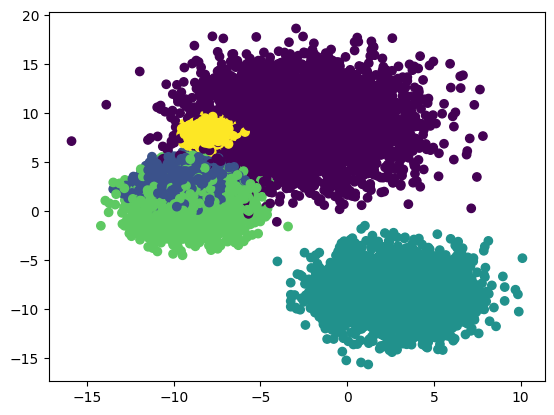

In [6]:
N = 20000
K = 100

X, y = make_blobs(
    n_samples=N,
    n_features=K,
    centers=5,
    cluster_std=[3,1,2,1.5,0.5],
    random_state=42
)

plt.scatter(X[:, 0], X[:, 1], c=y)

In [7]:
clusterer = hdbscan.HDBSCAN()
%time clusterer.fit(X)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CPU times: user 46.1 s, sys: 128 ms, total: 46.3 s
Wall time: 46.7 s


HDBSCAN()

In [8]:
print(silhouette_score(X, clusterer.labels_))

0.7352694189002873


In [5]:
%load_ext cuml.accel

[2025-03-10 20:36:10.574] [CUML] [info] cuML: Installed accelerator for sklearn.
[2025-03-10 20:36:21.844] [CUML] [info] cuML: Installed accelerator for umap.
[2025-03-10 20:36:21.845] [CUML] [info] cuML: Installed accelerator for hdbscan.
[2025-03-10 20:36:21.845] [CUML] [info] cuML: Successfully initialized accelerator.


In [6]:
import hdbscan

In [7]:
clusterer = hdbscan.HDBSCAN()
%time clusterer.fit(X)


CPU times: user 632 ms, sys: 185 ms, total: 816 ms
Wall time: 1.03 s


HDBSCAN()

Here we go from around 45 seconds to 1 second to fit the clustering model! This is a massive speed-up we got just from loading the `cuml.accel` extension.

In [8]:
print(silhouette_score(X, clusterer.labels_))


0.7226569165160748



It's important to note that on real-world datasets, the silhouette score produced by the GPU and CPU implementations of HDBSCAN will often have slight differences. The cuML implementation of HDBSCAN should provide equivalent results, but it is normal for the actual clusters to vary slightly when dealing with complex datasets.

Lastly, let's take a look at how we can use cuml's accelerator mode for a third popular machine learning task -- dimensionality reduction. We'll restart the kernel to unload the extension yet again.

Keep in mind that we don't normally need to restart the kernel when using `cuml.accel`, we just do it for the sake of showing the speed-ups in this demo. In practice, you'd just load the accelerator one time up front and be set.

In [9]:
get_ipython().kernel.do_shutdown(restart=True)

{'status': 'ok', 'restart': True}

# Dimensionality Reduction

UMAP is a popular dimensionality reduction technique that is used for both data visualization and as preprocessing for downstream modeling due to its ability to balance preserving both local and global structure of high-dimensional data. To learn more about how it works, visit the [UMAP documentation](https://umap-learn.readthedocs.io/en/latest/).

To explore how cuML can accelerate UMAP, let's load in another dataset from UCI. We'll use the Human Activity Recognition (HAR) dataset, which was created from recordings of 30 subjects performing activities of daily living (ADL) while carrying a waist-mounted smartphone with embedded inertial sensors.

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip -O /tmp/HAR_data.zip

--2025-03-10 20:39:18--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘/tmp/HAR_data.zip’

/tmp/HAR_data.zip       [                 <=>]  58.17M  17.0MB/s    in 4.4s    

2025-03-10 20:39:24 (13.3 MB/s) - ‘/tmp/HAR_data.zip’ saved [60999314]



In [2]:
!unzip /tmp/HAR_data.zip -d /tmp/HAR_data/

Archive:  /tmp/HAR_data.zip
replace /tmp/HAR_data/UCI HAR Dataset/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [8]:
import pandas as pd

X_train = pd.read_csv("/tmp/HAR_data/UCI HAR Dataset/train/X_train.txt", sep="\s+", header=None)
y_train = pd.read_csv("/tmp/HAR_data/UCI HAR Dataset/train/y_train.txt", sep="\s+", header=None)
X_test = pd.read_csv("/tmp/HAR_data/UCI HAR Dataset/test/X_test.txt", sep="\s+", header=None)
y_test = pd.read_csv("/tmp/HAR_data/UCI HAR Dataset/test/y_test.txt", sep="\s+", header=None)
labels = pd.read_csv("/tmp/HAR_data/UCI HAR Dataset/activity_labels.txt", sep="\s+", header=None)

In [9]:
X_train.shape

(7352, 561)

Let's take a look at the activity labels to better understand the data we're working with. We can see that the sensors have grouped activities into 6 different classes.

In [10]:
labels

,0,1
0,1,WALKING
1,2,WALKING_UPSTAIRS
2,3,WALKING_DOWNSTAIRS
3,4,SITTING
4,5,STANDING
5,6,LAYING


In [15]:
from sklearn.preprocessing import StandardScaler

# Scale the data before applying UMAP
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)


Let's run UMAP with some basic parameters and explore a lower-dimensionality projection of this dataset.

In [12]:
import umap
umap_model = umap.UMAP(n_neighbors=15, n_components=2, random_state=42, min_dist=0.0)

In [13]:
%%time

# Fit UMAP model to the data
X_train_umap = umap_model.fit_transform(X_train_scaled)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


CPU times: user 36.6 s, sys: 1.09 s, total: 37.6 s
Wall time: 52.2 s


It's often quite interesting to visualize the resulting projection of the embeddings created by UMAP. In this case, let's take a look at the now 2-dimensional dataset.

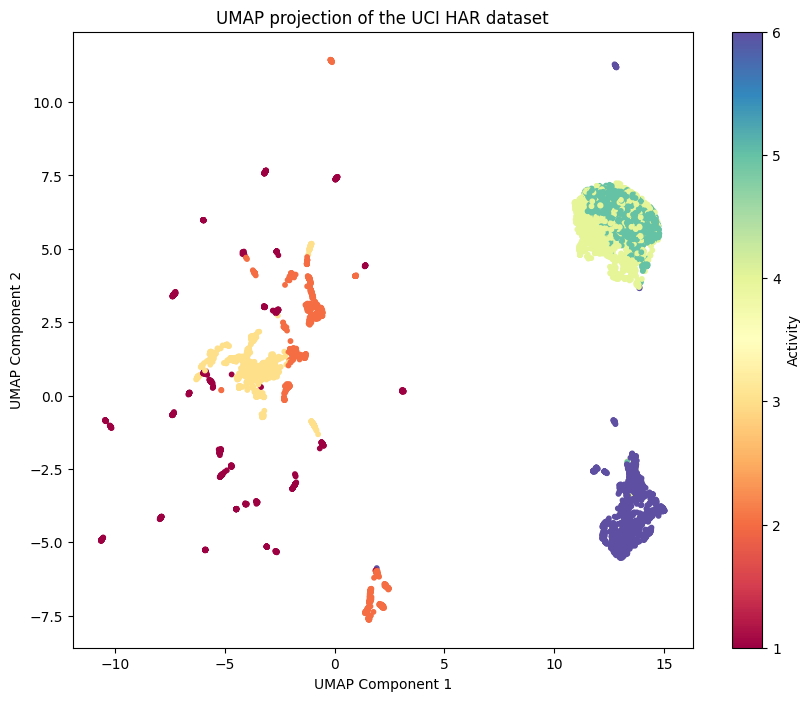

In [16]:
import matplotlib.pyplot as plt

# Plot the UMAP result
plt.figure(figsize=(10, 8))
plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train.values.ravel(), cmap='Spectral', s=10)
plt.colorbar(label="Activity")
plt.title("UMAP projection of the UCI HAR dataset")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()


It's interesting to see how our different categories are grouped in relation to one another.

We can look at the trustworthiness score to better understand how well the structure of the original dataset was preserved by our 2D projection

In [17]:
from sklearn.manifold import trustworthiness
trustworthiness(X_train, X_train_umap, n_neighbors=15)


0.9725294692634925

It looks like this projection is a great representation of our full dataset.

Let's now run the same thing with the accelerator turned on.

In [18]:
%load_ext cuml.accel

[2025-03-10 20:42:01.171] [CUML] [info] cuML: Installed accelerator for sklearn.
[2025-03-10 20:42:01.172] [CUML] [info] cuML: Installed accelerator for umap.
[2025-03-10 20:42:01.183] [CUML] [info] cuML: Installed accelerator for hdbscan.
[2025-03-10 20:42:01.183] [CUML] [info] cuML: Successfully initialized accelerator.


In [19]:
import umap
umap_model = umap.UMAP(n_neighbors=15, n_components=2, random_state=42, min_dist=0.0)

[2025-03-10 20:42:01.192] [CUML] [info] build_algo set to brute_force_knn because random_state is given


In [20]:
%%time

# Fit UMAP model to the data
X_train_umap = umap_model.fit_transform(X_train_scaled)

CPU times: user 372 ms, sys: 152 ms, total: 523 ms
Wall time: 520 ms


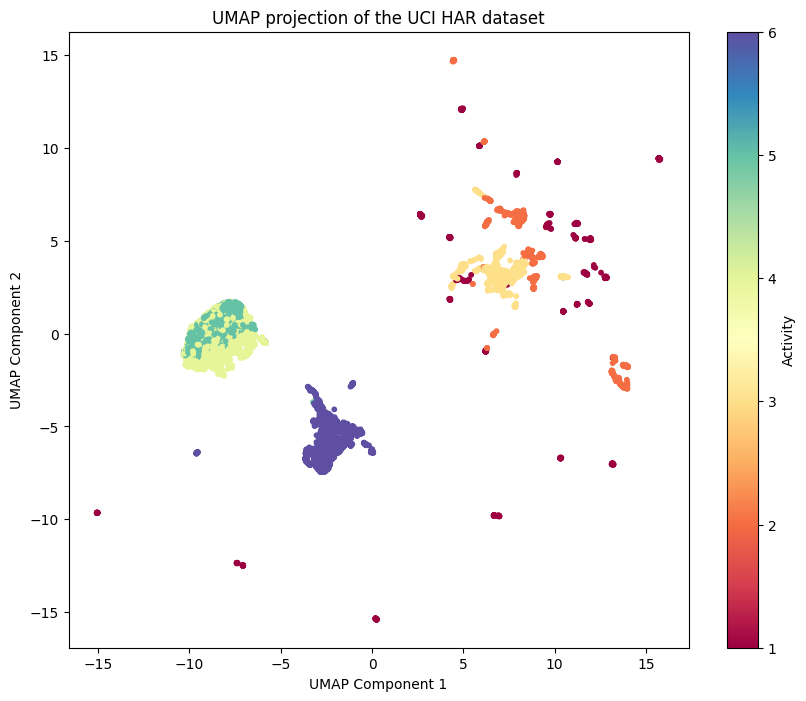

In [21]:
import matplotlib.pyplot as plt

# Plot the UMAP result
plt.figure(figsize=(10, 8))
plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train.values.ravel(), cmap='Spectral', s=10)
plt.colorbar(label="Activity")
plt.title("UMAP projection of the UCI HAR dataset")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()


Note that while the projection here is not identical to the umap-learn plot, the quality of the results are equivalent. We can run the trustworthiness score again to compare and verify this claim.

In [22]:
from sklearn.manifold import trustworthiness
trustworthiness(X_train, X_train_umap, n_neighbors=15)


0.9709069888612091

For more information on getting started with `cuml.accel`, check out [RAPIDS.ai](https://rapids.ai/cuml-accel/) or the [cuML Docs](https://docs.rapids.ai/api/cuml/stable/).